### Imports

In [2]:
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
# import gym_anytrading

import sys
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading")
import importlib
%load_ext autoreload
%autoreload 2
from envs import MyForexEnv
# sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/")
# from datasets import FOREX_EURUSD_RENKO
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback
import torch

### Create Env

In [3]:
import os
name = 'FOREX_EURUSD_RENKO'
# base_dir = os.path.dirname(os.path.abspath(__file__))
path = "C:/Users/WilliamFetzner/Documents/Trading/gym-anytrading/gym_anytrading/datasets/data/renko_full_data_81.csv"
# path = os.path.join(base_dir, '.csv')
FOREX_EURUSD_RENKO = pd.read_csv(path, parse_dates=True, index_col='datetime')

In [7]:
%autoreload 2
from envs import MyForexEnv
env_name = 'MyForexEnv'
# df, window_size, frame_bound, unit_side='right', render_mode=None, **kwargs
env = MyForexEnv(
    df=FOREX_EURUSD_RENKO,
    window_size=10,
    frame_bound=(10, int(len(FOREX_EURUSD_RENKO)*.8)),
    trade_fee=0.0001,
    unit_side='right',
    sma_length=4,
    smoothing_sma=4
)

### Define Functions

In [8]:
def print_stats(reward_over_episodes):
    """  Print Reward  """

    avg = np.mean(reward_over_episodes)
    min = np.min(reward_over_episodes)
    max = np.max(reward_over_episodes)

    print (f'Min. Reward          : {min:>10.3f}')
    print (f'Avg. Reward          : {avg:>10.3f}')
    print (f'Max. Reward          : {max:>10.3f}')

    return min, avg, max


# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


# TRAINING + TEST
def train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps=10_000):
    """ if model=None then execute 'Random actions' """

    # reproduce training and test
    print('-' * 80)
    obs = env.reset(seed=seed)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    vec_env = None

    if model is not None:
        print(f'model {type(model)}')
        print(f'policy {type(model.policy)}')
        # print(f'model.learn(): {total_learning_timesteps} timesteps ...')

        # custom callback for 'progress_bar'
        model.learn(total_timesteps=total_learning_timesteps, callback=ProgressBarCallback(100))
        # model.learn(total_timesteps=total_learning_timesteps, progress_bar=True)
        # ImportError: You must install tqdm and rich in order to use the progress bar callback. 
        # It is included if you install stable-baselines with the extra packages: `pip install stable-baselines3[extra]`

        vec_env = model.get_env()
        obs = vec_env.reset()
    else:
        print ("RANDOM actions")

    reward_over_episodes = []
    # profit_over_episodes = []
    # max_profit_over_episodes = []

    tbar = tqdm(range(total_num_episodes))

    for episode in tbar:
        
        if vec_env: 
            obs = vec_env.reset()
        else:
            obs, info = env.reset()

        total_reward = 0
        # total_profit = 0
        # total_max_profit = 0
        done = False

        while not done:
            if model is not None:
                action, _states = model.predict(obs)
                obs, reward, done, info = vec_env.step(action)
            else: # random
                action = env.action_space.sample()
                obs, reward, terminated, truncated, info = env.step(action)
                done = terminated or truncated

            total_reward += reward
            if done:
                # total_profit = info['total_profit']
                # if model is not None:
                #     total_max_profit = vec_env.unwrapped.max_possible_profit()
                # else: # random
                #     total_max_profit = env.unwrapped.max_possible_profit()
                break

        reward_over_episodes.append(total_reward)
        # profit_over_episodes.append(total_profit)
        # max_profit_over_episodes.append(total_max_profit)

        if episode % 10 == 0:
            avg_reward = np.mean(reward_over_episodes)
            tbar.set_description(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}')
            tbar.update()

    tbar.close()
    avg_reward = np.mean(reward_over_episodes)

    return reward_over_episodes#, max_profit_over_episodes#, profit_over_episodes

### Train + Test Env

In [9]:
seed = 42  # random seed
total_num_episodes = 50

print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# Random actions
model = None 
total_learning_timesteps = 0
rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps)
min, avg, max = print_stats(rewards)
class_name = f'Random actions'
label = f'Avg. {avg:>7.2f} : {class_name}'
plot_data['rnd_rewards'] = rewards
plot_settings['rnd_rewards'] = {'label': label}

learning_timesteps_list_in_K = [25]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html
model_class_list = [A2C, PPO]

for timesteps in learning_timesteps_list_in_K:
    total_learning_timesteps = timesteps * 1000
    step_key = f'{timesteps}K'

    for model_class in model_class_list:
        policy_dict = model_class.policy_aliases
        # https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
        # MlpPolicy or MlpLstmPolicy
        policy = policy_dict.get('MlpPolicy')
        if policy is None:
            policy = policy_dict.get('MlpLstmPolicy')
        # print ('policy:', policy, 'model_class:', model_class)

        try:
            model = model_class(policy, env, verbose=0)
            class_name = type(model).__qualname__
            plot_key = f'{class_name}_rewards_'+step_key
            rewards = train_test_model(model, env, seed, total_num_episodes, total_learning_timesteps) # , total_profit , max_profit
            min, avg, max, = print_stats(rewards)
            # min_tp, avg_tp, max_tp, = print_stats(total_profit)
            # min_mp, avg_mp, max_mp, = print_stats(max_profit)
            label = f'Avg. {avg:>7.2f} : {class_name} - {step_key}'
            plot_data[plot_key] = rewards
            plot_settings[plot_key] = {'label': label}     
                   
        except Exception as e:
            print(f"ERROR: {str(e)}")
            continue

env_name                 : MyForexEnv
seed                     : 42
--------------------------------------------------------------------------------
RANDOM actions


Episode: 40, Avg. Reward: -413.164: 100%|██████████| 50/50 [00:05<00:00,  9.37it/s]


Min. Reward          :   -413.164
Avg. Reward          :   -413.164
Max. Reward          :   -413.164
--------------------------------------------------------------------------------
model <class 'stable_baselines3.a2c.a2c.A2C'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


Episode: 40, Avg. Reward: 152.340: 100%|██████████| 50/50 [03:07<00:00,  3.76s/it]


Min. Reward          :  -1417.447
Avg. Reward          :    172.550
Max. Reward          :   1871.136
--------------------------------------------------------------------------------
model <class 'stable_baselines3.ppo.ppo.PPO'>
policy <class 'stable_baselines3.common.policies.ActorCriticPolicy'>


model.learn(): 26600it [00:58, 456.78it/s]                            
Episode: 40, Avg. Reward: 79.605: 100%|██████████| 50/50 [02:49<00:00,  3.40s/it] 

Min. Reward          :  -1652.379
Avg. Reward          :     87.623
Max. Reward          :   1571.296


### Plot Results

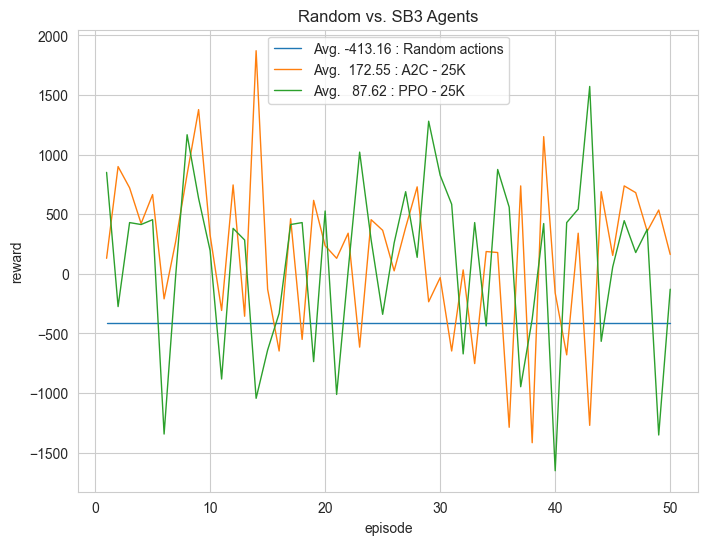

In [ ]:
data = pd.DataFrame(plot_data)

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))

for key in plot_data:
    if key == 'x':
        continue
    label = plot_settings[key]['label']
    line = plt.plot('x', key, data=data, linewidth=1, label=label)

plt.xlabel('episode')
plt.ylabel('reward')
plt.title('Random vs. SB3 Agents')
plt.legend()
plt.show()

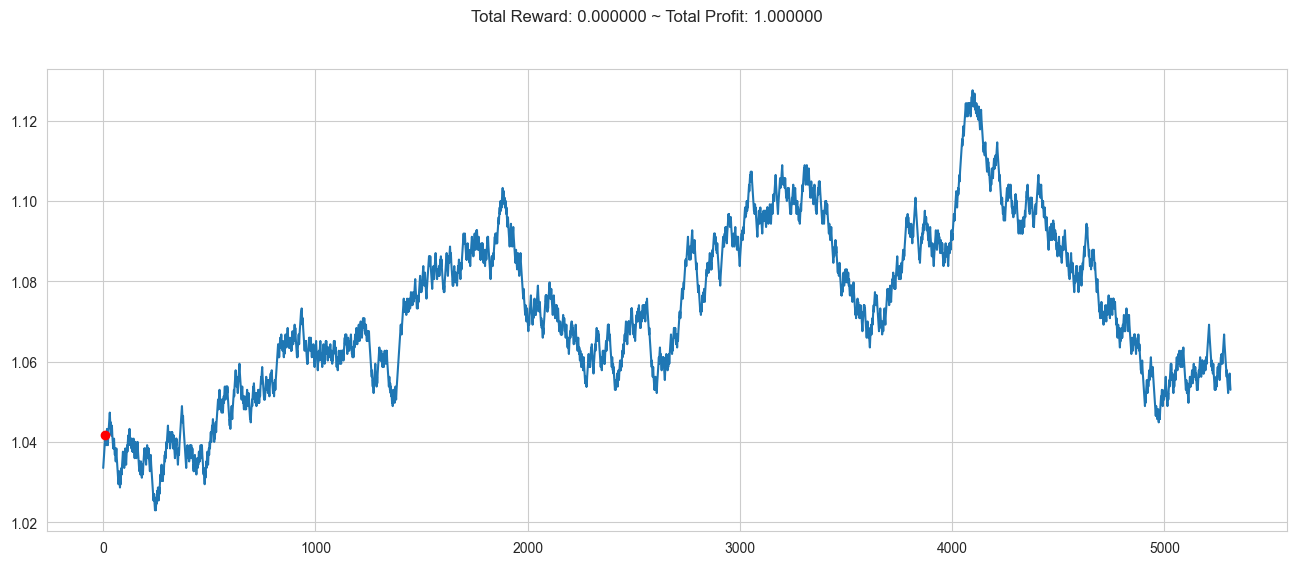

In [ ]:
plt.figure(figsize=(16, 6))
plt.cla()
env.unwrapped.render_all()
plt.show()

In [ ]:
print("> max_possible_profit:", env.unwrapped.max_possible_profit())
print("> signal_features.shape:", env.unwrapped.signal_features.shape)

> max_possible_profit: 13.389417032121775
> signal_features.shape: (5312, 14)
